# Step 6 – Insights & Visuals (Business Report)

This notebook converts the analytical marts into:
- Executive insights (8–12)
- Dashboard-ready visuals (PNG + SVG)
- Interview talking points for Data Engineer / Analytics Engineer / Data Analyst roles

Notes:
- Dataset is snapshot-like (Jan 1 dates). Do not claim intra-year seasonality unless the data supports it.
- Fact table is strict: ~0.22% rows excluded due to missing trade_name (documented earlier).


In [6]:
PALETTE = [
    "#4E79A7",  # blue
    "#F28E2B",  # orange
    "#E15759",  # red
    "#76B7B2",  # teal
    "#59A14F",  # green
    "#EDC948",  # yellow
    "#B07AA1",  # purple
    "#FF9DA7",  # pink
    "#9C755F",  # brown
    "#BAB0AC",  # grey
]

def apply_common_format(ax):
    ax.grid(axis="y", alpha=0.25)
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# Crisp inline
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 140,
    "savefig.dpi": 320,
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})

PALETTE = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F","#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]
HIGHLIGHT = "#4E79A7"
MUTED = "#D0D0D0"

def fmt_commas(x, pos):
    try:
        return f"{int(x):,}"
    except Exception:
        return str(x)

comma_formatter = FuncFormatter(fmt_commas)

def polish_axes(ax):
    ax.grid(True, alpha=0.22)
    ax.set_axisbelow(True)
    ax.spines["left"].set_alpha(0.3)
    ax.spines["bottom"].set_alpha(0.3)
    return ax

OUT_DIR = Path("../outputs/insights")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{name}.png", bbox_inches="tight")
    plt.savefig(OUT_DIR / f"{name}.svg", bbox_inches="tight")


Connect to DuckDB + load marts

In [2]:
DB_PATH = Path("../data/duckdb/motorcycle.db")
con = duckdb.connect(str(DB_PATH), read_only=True)

# Core marts
market_share = con.execute("SELECT * FROM mart_market_share_monthly").fetchdf()
yoy = con.execute("SELECT * FROM mart_yoy_growth_manufacturer").fetchdf()
state_rank = con.execute("SELECT * FROM mart_state_manufacturer_rank").fetchdf()
pareto = con.execute("SELECT * FROM mart_model_pareto").fetchdf()

# Convenience: overall monthly totals (from view)
monthly_total = con.execute("""
SELECT year_month, year, month, SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY 1,2,3
ORDER BY 1
""").fetchdf()

yearly_total = con.execute("""
SELECT year, SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY 1
ORDER BY 1
""").fetchdf()

yearly_total


,year,registrations
0,2023,4910141.0
1,2024,4987191.0
2,2025,5056626.0


INSIGHTS SECTION

In [3]:
insights = []

# Insight 1: Market size trend (yearly)
if len(yearly_total) >= 2:
    y0, y1 = yearly_total.iloc[-2], yearly_total.iloc[-1]
    pct = (y1["registrations"] - y0["registrations"]) / y0["registrations"] * 100
    insights.append({
        "Insight": "Market trend (yearly)",
        "Metric": f"{int(y0['year'])} → {int(y1['year'])}",
        "Value": f"{pct:.2f}% YoY",
        "So what": "Market appears mature; growth is modest. Use share and segment wins to tell performance."
    })

# Insight 2: Latest month total + direction (if multiple months exist)
if len(monthly_total) >= 2:
    m0, m1 = monthly_total.iloc[-2], monthly_total.iloc[-1]
    pctm = (m1["registrations"] - m0["registrations"]) / m0["registrations"] * 100 if m0["registrations"] else None
    insights.append({
        "Insight": "Latest period change (monthly totals)",
        "Metric": f"{m0['year_month']} → {m1['year_month']}",
        "Value": f"{pctm:.2f}%" if pctm is not None else "n/a",
        "So what": "Shows directionality; use alongside manufacturer movement for a narrative."
    })

# Insight 3: Top manufacturer overall
top_m = con.execute("""
SELECT manufacturer, SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY 1
ORDER BY registrations DESC
LIMIT 1
""").fetchdf()

if len(top_m):
    insights.append({
        "Insight": "Market leader",
        "Metric": top_m.loc[0, "manufacturer"],
        "Value": f"{int(top_m.loc[0, 'registrations']):,}",
        "So what": "Leader usually drives expectations; benchmark challengers against it."
    })

# Insight 4: Top 5 share in latest month
latest_month = market_share["year_month"].max()
top5_latest = (market_share[market_share["year_month"] == latest_month]
               .sort_values("market_share_pct", ascending=False)
               .head(5))

insights.append({
    "Insight": "Top 5 manufacturers in latest month",
    "Metric": latest_month,
    "Value": ", ".join(top5_latest["manufacturer"].tolist()),
    "So what": "Defines competitive set for dashboards and regional breakdowns."
})

# Insight 5: Most improved YoY manufacturer (latest year)
latest_year = yoy["year"].max()
yoy_latest = yoy[(yoy["year"] == latest_year) & (yoy["yoy_growth_pct"].notna())].copy()
if len(yoy_latest):
    best = yoy_latest.sort_values("yoy_growth_pct", ascending=False).iloc[0]
    insights.append({
        "Insight": "Fastest growing manufacturer (YoY)",
        "Metric": f"{int(latest_year)}",
        "Value": f"{best['manufacturer']} ({best['yoy_growth_pct']:.2f}%)",
        "So what": "Flag for deeper drill-down: which states/models drove the change?"
    })

# Insight 6: Largest manufacturer concentration by state (top1 share)
# For each state, find top manufacturer registrations and total
state_top = con.execute("""
WITH totals AS (
  SELECT state, manufacturer, registrations
  FROM mart_state_manufacturer_rank
),
state_sum AS (
  SELECT state, SUM(registrations) AS total
  FROM totals
  GROUP BY 1
),
state_best AS (
  SELECT
    t.state, t.manufacturer, t.registrations,
    s.total,
    (100.0 * t.registrations / NULLIF(s.total,0)) AS share_pct,
    ROW_NUMBER() OVER (PARTITION BY t.state ORDER BY t.registrations DESC) AS rn
  FROM totals t
  JOIN state_sum s USING(state)
)
SELECT * FROM state_best WHERE rn=1 ORDER BY share_pct DESC LIMIT 1
""").fetchdf()

if len(state_top):
    row = state_top.iloc[0]
    insights.append({
        "Insight": "Most concentrated state (top manufacturer share)",
        "Metric": f"{row['state']}",
        "Value": f"{row['manufacturer']} ({row['share_pct']:.2f}%)",
        "So what": "Some regions are dominated by one brand; useful for targeting and retailer strategy."
    })

# Insight 7: Pareto — how many models contribute to 80%
pareto_80 = con.execute("""
SELECT COUNT(*) AS models_to_80
FROM mart_model_pareto
WHERE cumulative_share_pct <= 80
""").fetchdf()

total_models = con.execute("SELECT COUNT(*) AS total_models FROM dim_model_keyed").fetchdf()

if len(pareto_80) and len(total_models):
    insights.append({
        "Insight": "Model concentration (Pareto 80/20)",
        "Metric": "Models needed for 80% of registrations",
        "Value": f"{int(pareto_80.loc[0,'models_to_80']):,} / {int(total_models.loc[0,'total_models']):,}",
        "So what": "A small set of models drives most volume; prioritize these in analytics + inventory storytelling."
    })

# Insight 8: Unclassified/other state presence
sonstige = con.execute("""
SELECT SUM(registrations_count) AS regs
FROM vw_registrations
WHERE state='Sonstige'
""").fetchdf()

overall = con.execute("""
SELECT SUM(registrations_count) AS regs
FROM vw_registrations
""").fetchdf()

if len(sonstige) and len(overall):
    share = 100.0 * sonstige.loc[0,"regs"] / overall.loc[0,"regs"]
    insights.append({
        "Insight": "Data bucket: 'Sonstige' state share",
        "Metric": "All years",
        "Value": f"{share:.2f}%",
        "So what": "Track this as a data-quality bucket; include/exclude depending on reporting need."
    })

insights_df = pd.DataFrame(insights)
insights_df


,Insight,Metric,Value,So what
0,Market trend (yearly),2024 → 2025,1.39% YoY,Market appears mature; growth is modest. Use s...
1,Latest period change (monthly totals),2024-01 → 2025-01,1.39%,Shows directionality; use alongside manufactur...
2,Market leader,BMW,"1,921,982",Leader usually drives expectations; benchmark ...
3,Top 5 manufacturers in latest month,2025-01,"BMW, PIAGGIO (I), YAMAHA (J), SUZUKI (J), HOND...",Defines competitive set for dashboards and reg...
4,Fastest growing manufacturer (YoY),2025,ZHEJIANG CFMOTO (RC) (44.39%),Flag for deeper drill-down: which states/model...
5,Most concentrated state (top manufacturer share),Sonstige,BMW (19.33%),Some regions are dominated by one brand; usefu...
6,Model concentration (Pareto 80/20),Models needed for 80% of registrations,"707 / 2,812",A small set of models drives most volume; prio...
7,Data bucket: 'Sonstige' state share,All years,0.08%,Track this as a data-quality bucket; include/e...


## Executive Summary (Draft)

- The market shows modest growth, consistent with a mature category.
- Competitive dynamics are best explained by (1) market share movements and (2) product concentration.
- A small number of models drive a large share of volume (Pareto effect), indicating strong long-tail behavior.
- 'Sonstige' exists as a reporting bucket and should be tracked explicitly as a data-quality segment.


Dashboards

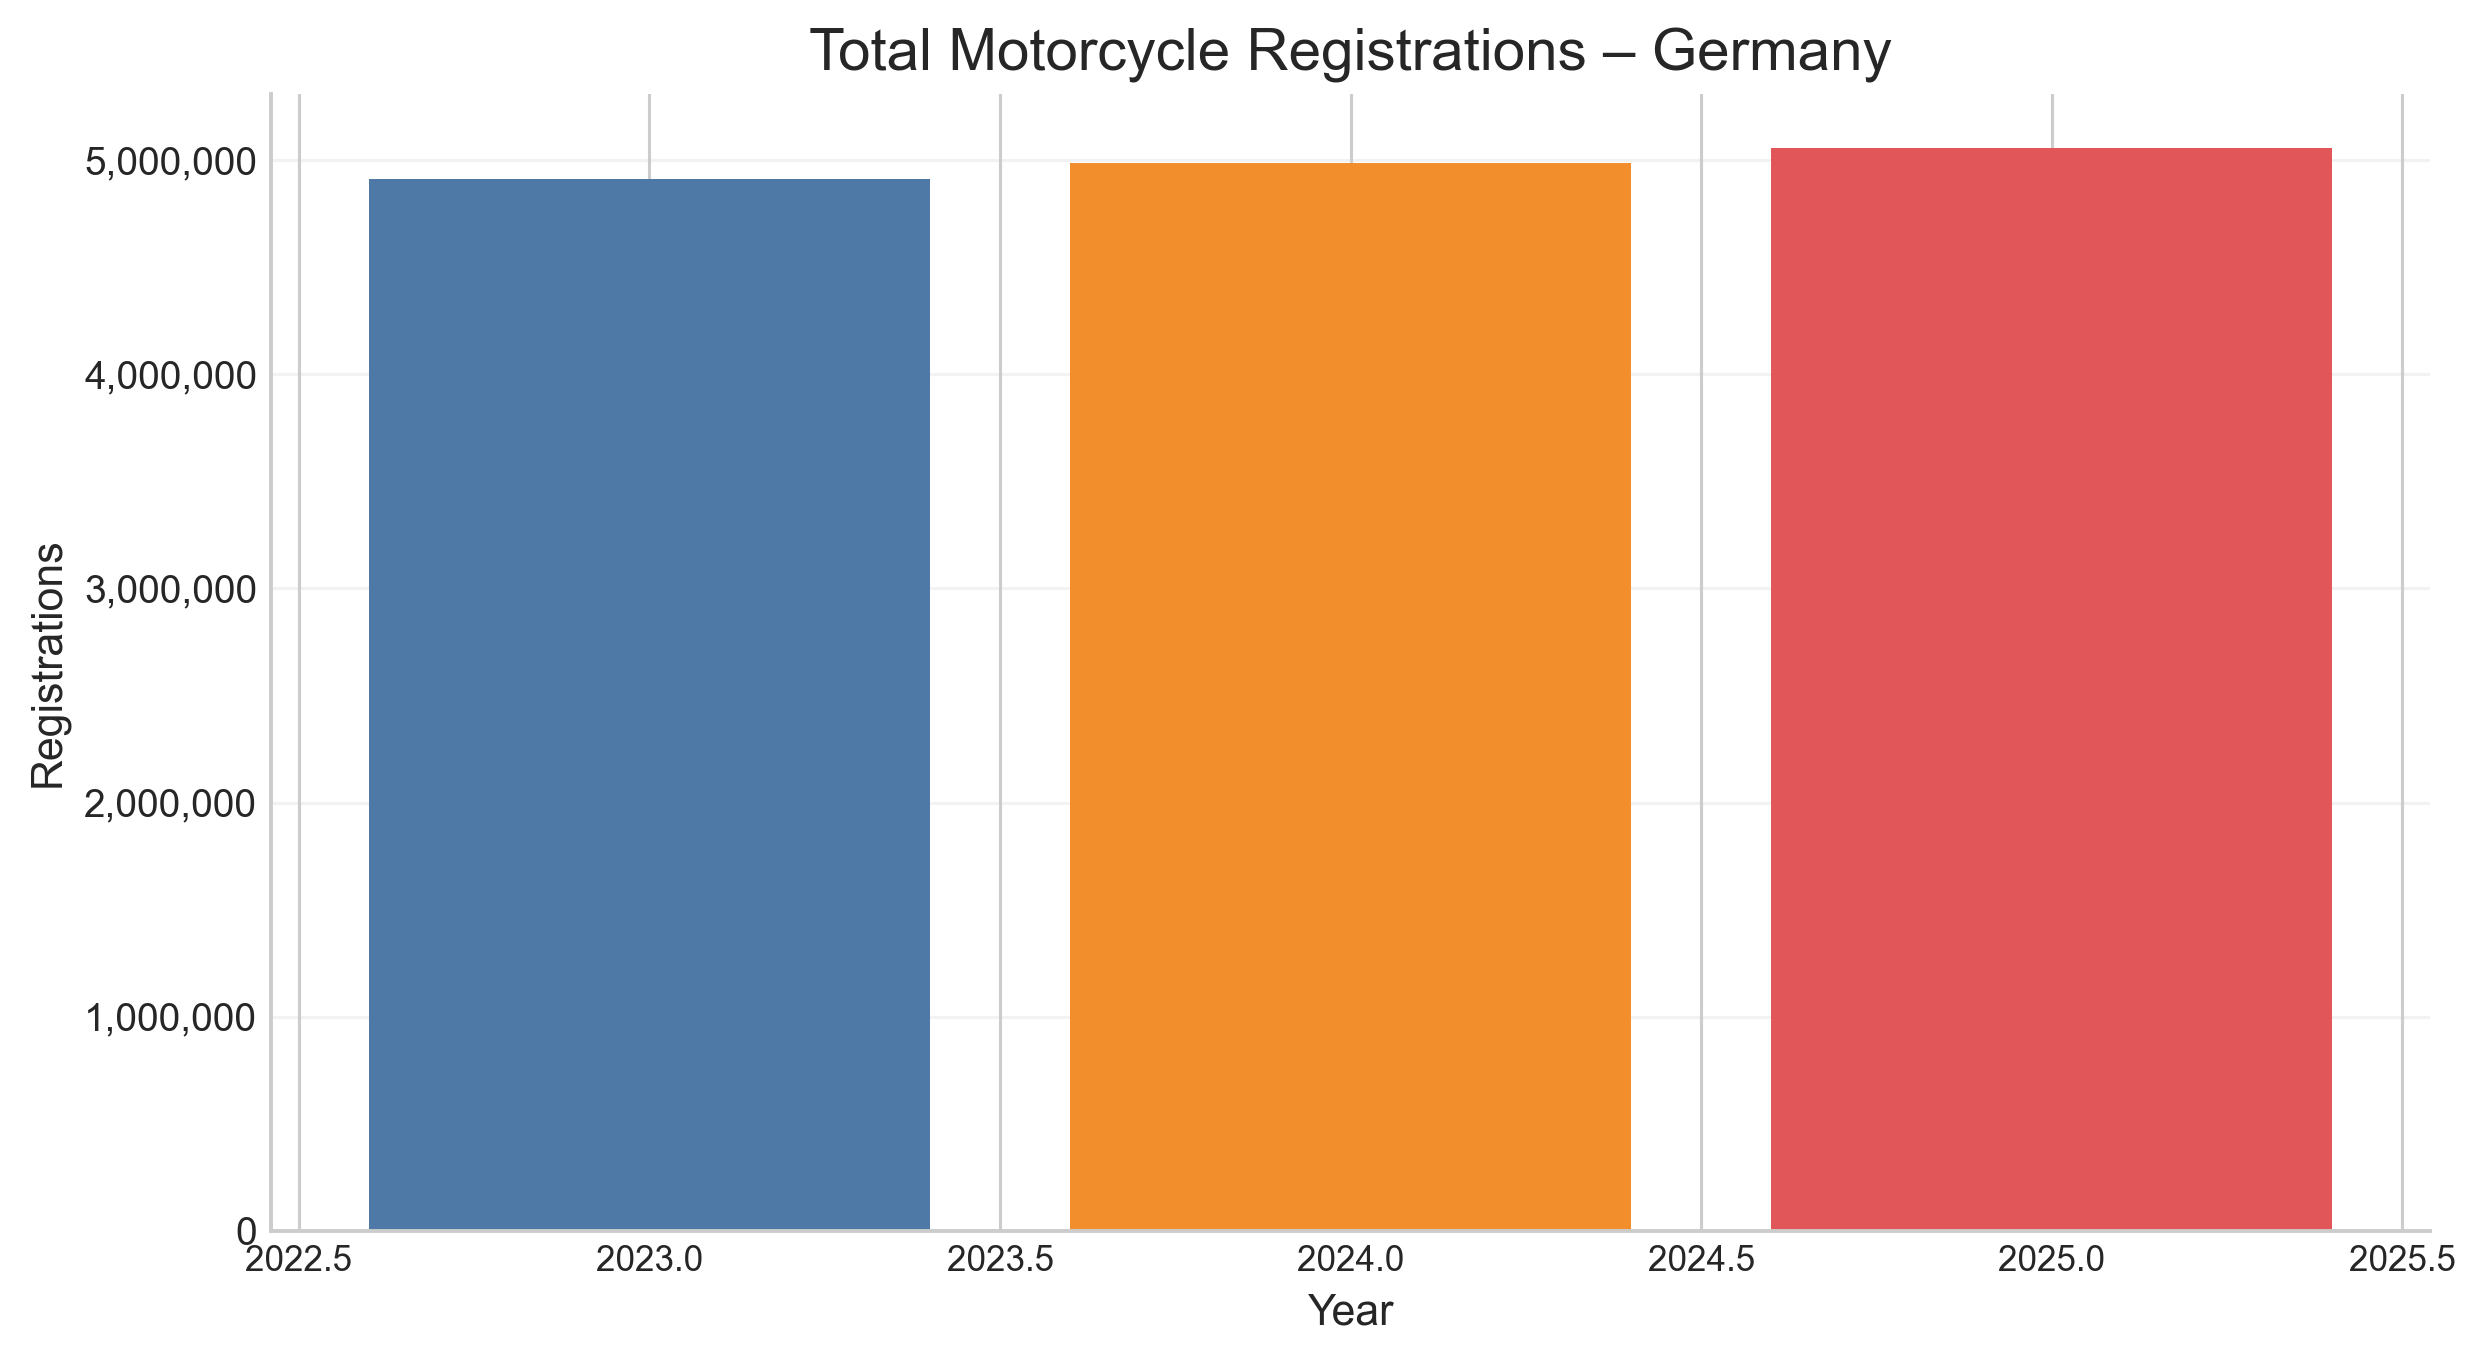

In [9]:
plt.figure(figsize=(9, 5))
ax = plt.gca()

ax.bar(
    yearly_total["year"],
    yearly_total["registrations"],
    color=PALETTE[:len(yearly_total)]
)

ax.set_title("Total Motorcycle Registrations – Germany")
ax.set_xlabel("Year")
ax.set_ylabel("Registrations")
ax.yaxis.set_major_formatter(comma_formatter)

apply_common_format(ax)
save_fig("01_market_total_bar")
plt.show()


📊 Chart 1 — Total Motorcycle Registrations (Germany)

What this chart shows:

Annual total motorcycle registrations in Germany.

Key finding:

The German motorcycle market shows only modest year-over-year growth, indicating a mature and largely saturated market rather than a rapidly expanding one.

Why this matters?

In a low-growth market, success is driven by market share gains, product differentiation, and regional strength, not overall market expansion. This sets the context for why brand-level performance must be evaluated relative to the market, not in isolation.

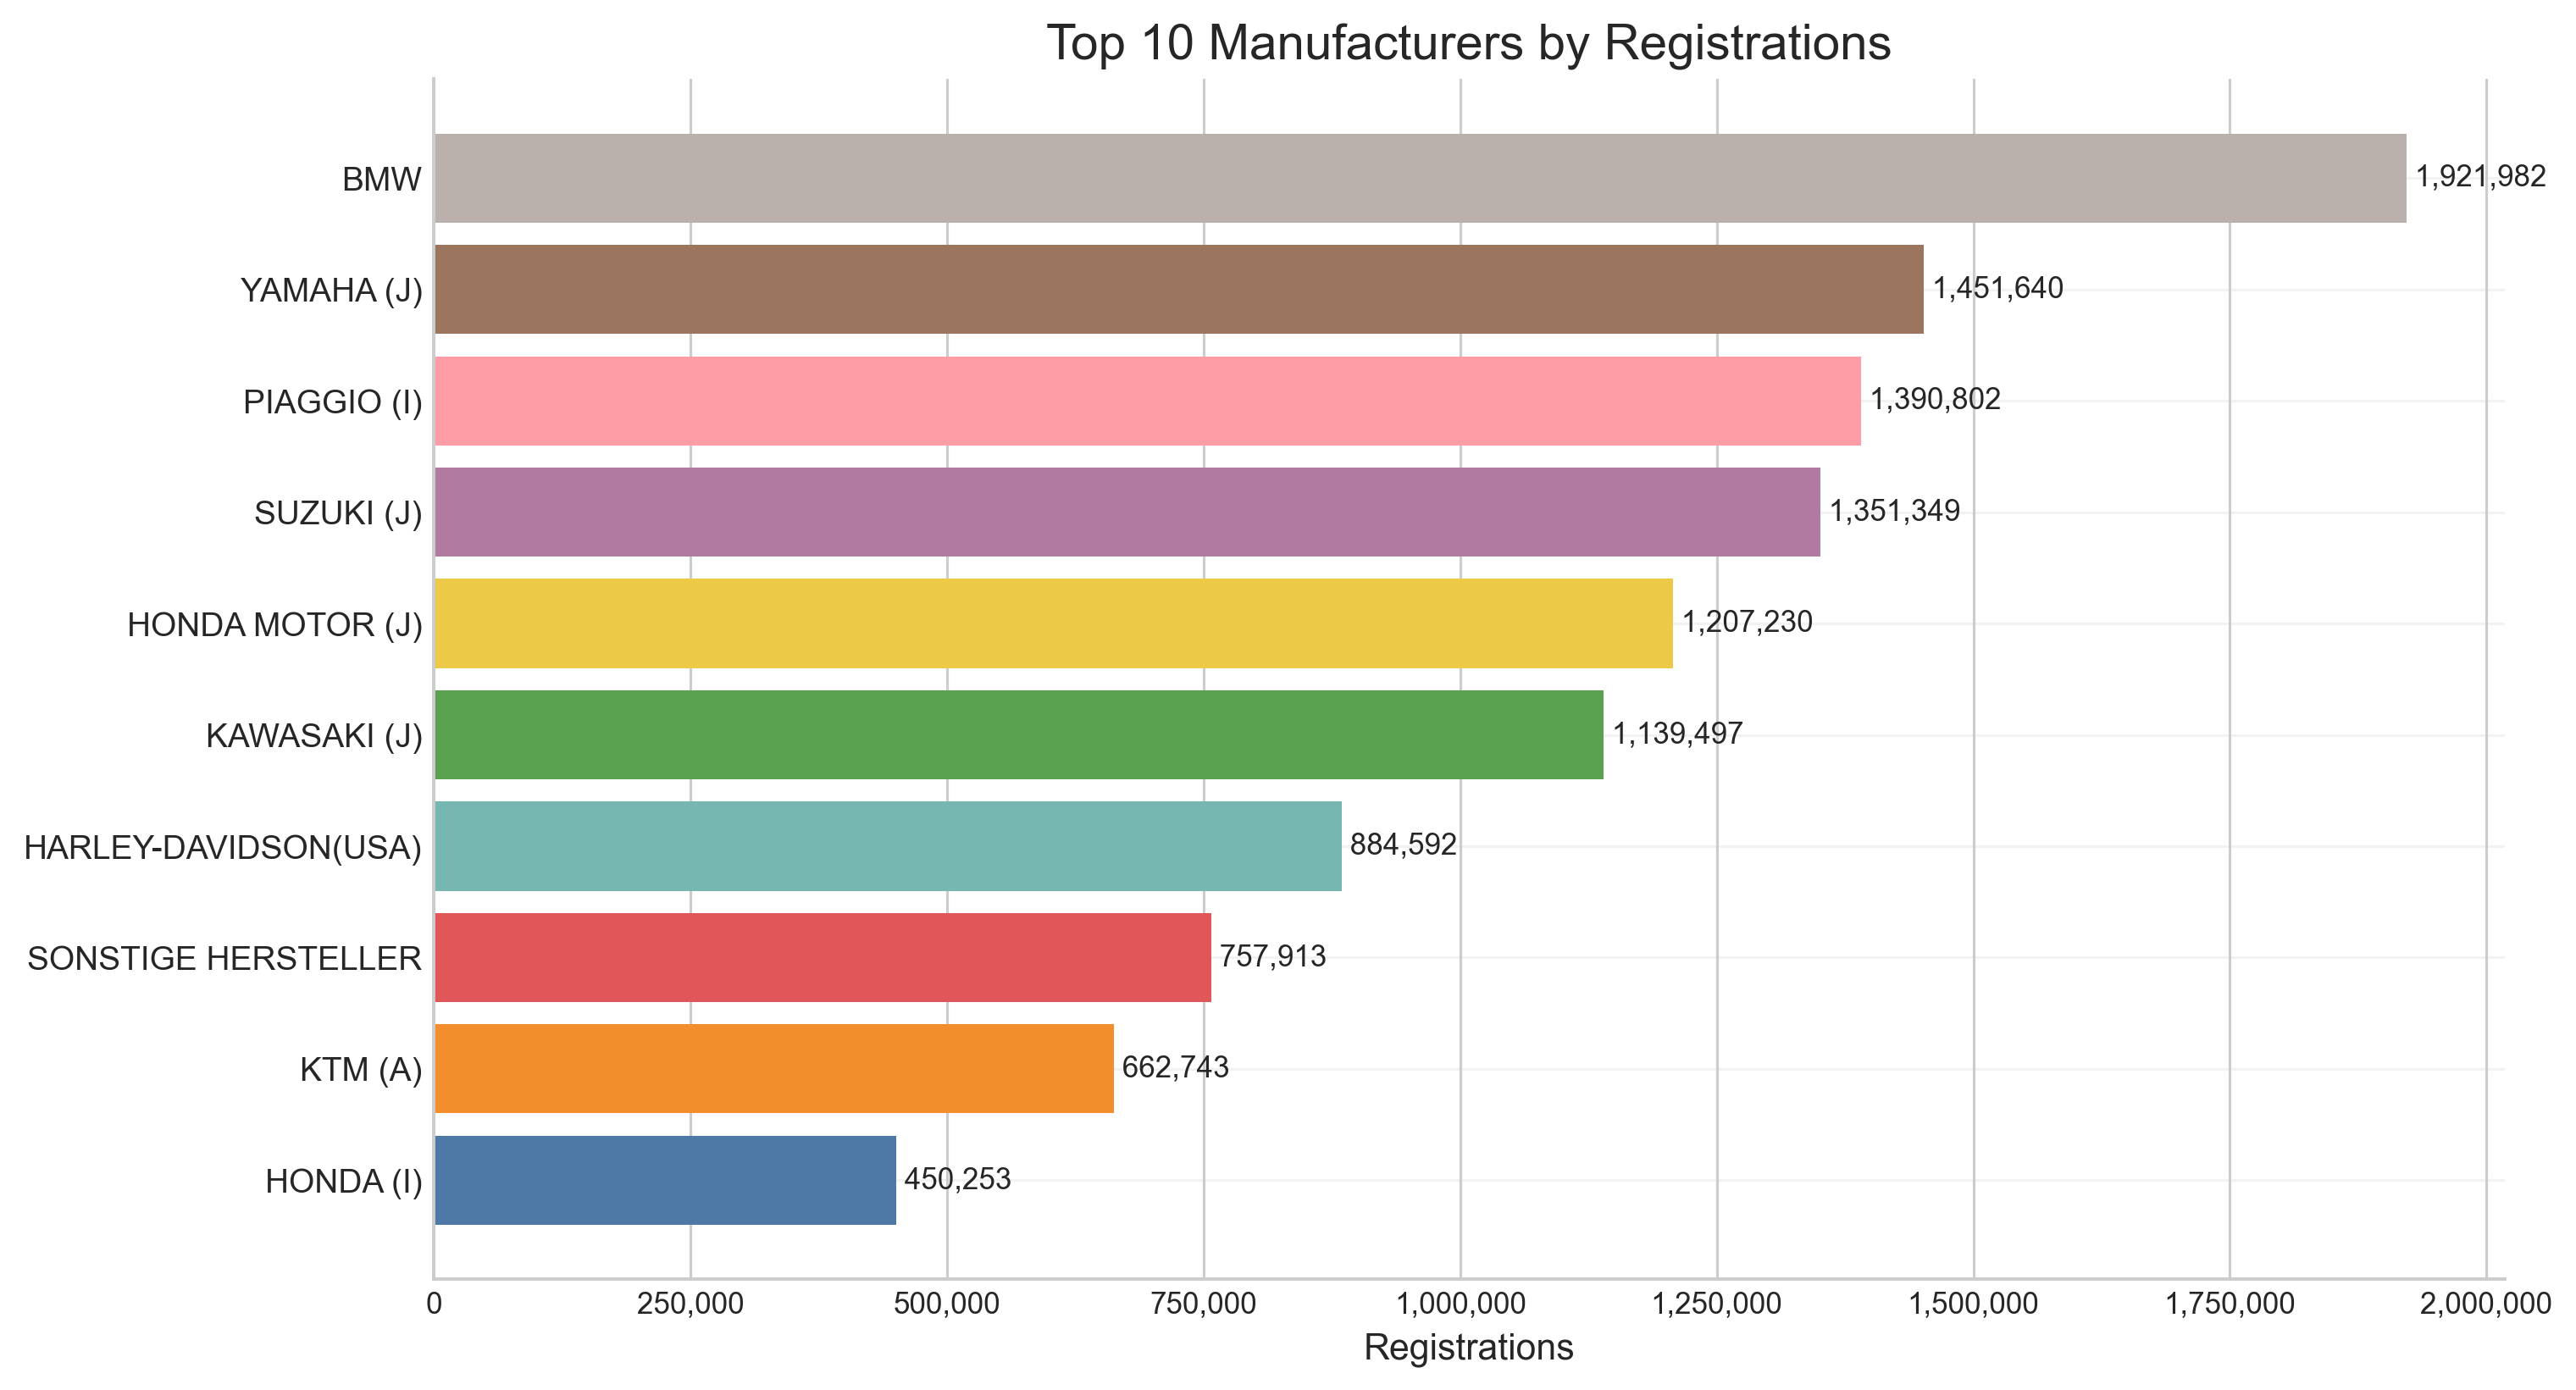

In [10]:
top10 = con.execute("""
SELECT manufacturer, SUM(registrations_count) AS registrations
FROM vw_registrations
GROUP BY 1
ORDER BY registrations DESC
LIMIT 10
""").fetchdf().iloc[::-1]

plt.figure(figsize=(11, 6))
ax = plt.gca()

ax.barh(
    top10["manufacturer"],
    top10["registrations"],
    color=PALETTE[:len(top10)]
)

ax.set_title("Top 10 Manufacturers by Registrations")
ax.set_xlabel("Registrations")
ax.xaxis.set_major_formatter(comma_formatter)

for i, v in enumerate(top10["registrations"]):
    ax.text(v, i, f" {int(v):,}", va="center", fontsize=9)

apply_common_format(ax)
save_fig("02_top10_manufacturers_multicolour")
plt.show()


📊 Chart 2 — Top 10 Manufacturers by Registrations

What this chart shows?

The ten largest motorcycle manufacturers in Germany by total registrations.

Key finding

The market is highly concentrated, with a small number of manufacturers accounting for a disproportionate share of total registrations.

Why this matters?

High concentration implies:

Strong incumbents
 - High barriers to entry
 - Limited room for organic growth
 - Challenger brands must therefore rely on segment-level wins or niche positioning rather than broad market dominance.

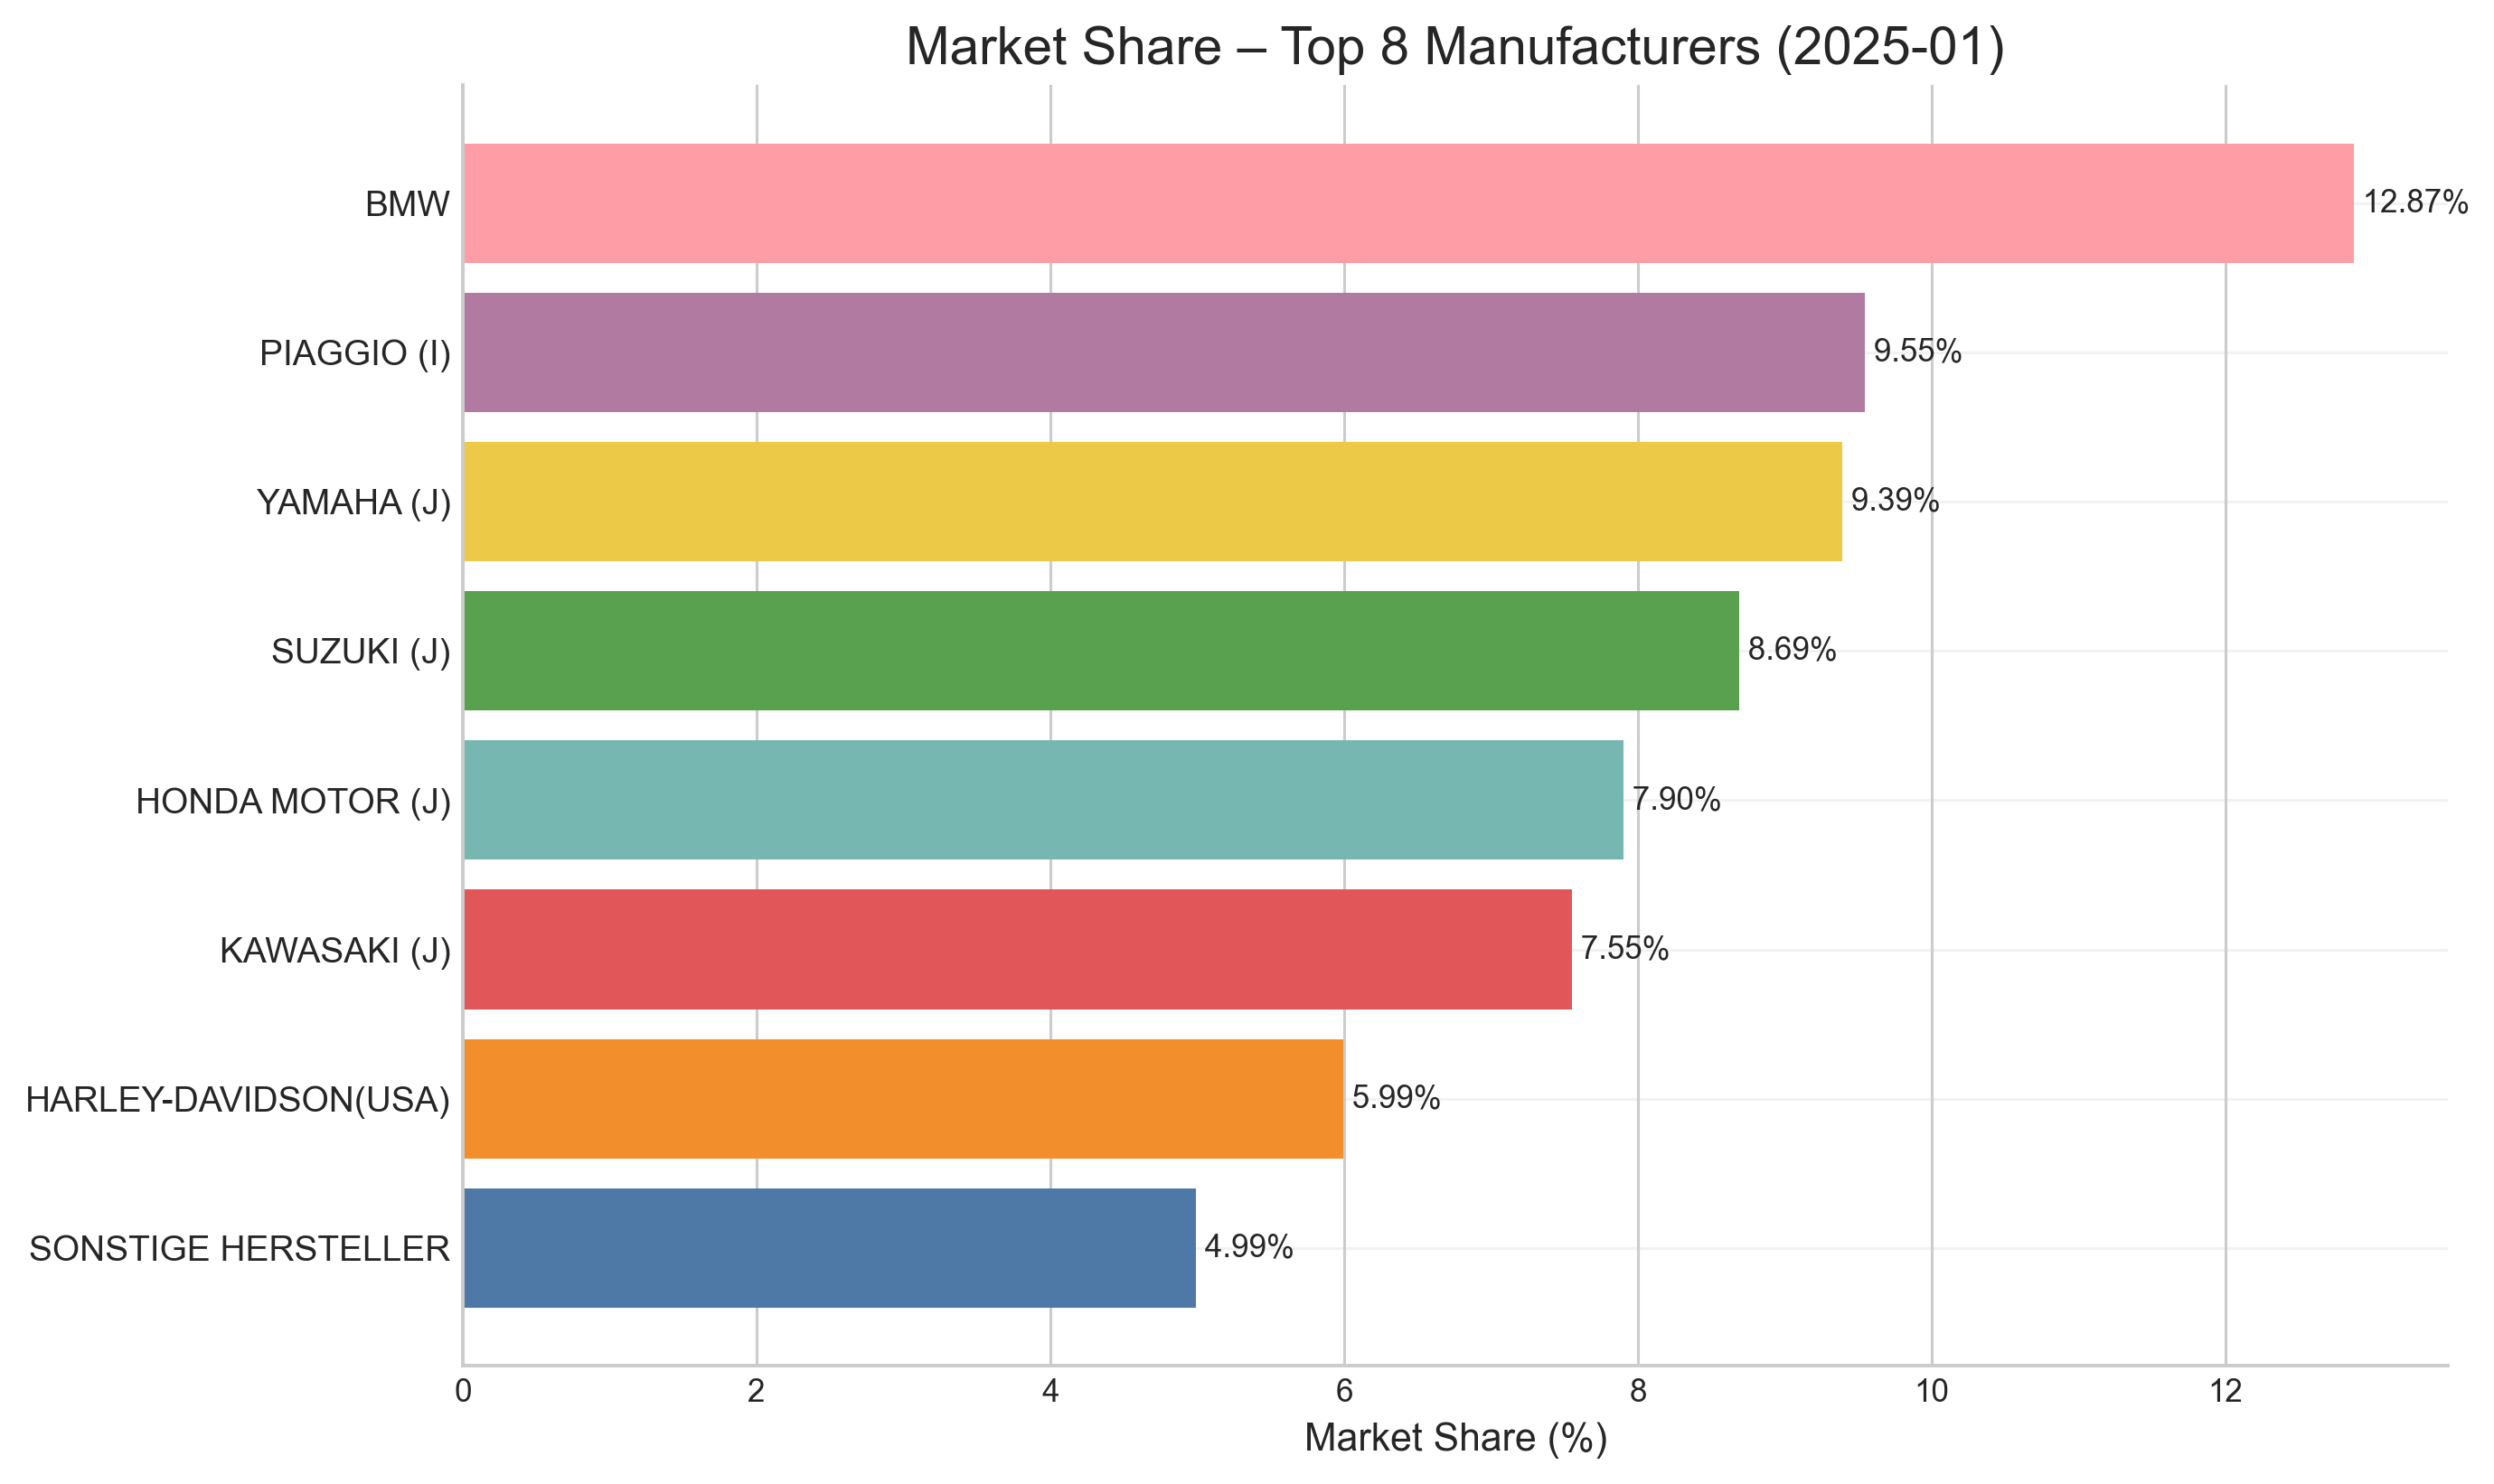

In [11]:
latest_month = market_share["year_month"].max()

top8 = (
    market_share[market_share["year_month"] == latest_month]
    .sort_values("market_share_pct", ascending=False)
    .head(8)
    .iloc[::-1]
)

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.barh(
    top8["manufacturer"],
    top8["market_share_pct"],
    color=PALETTE[:len(top8)]
)

ax.set_title(f"Market Share – Top 8 Manufacturers ({latest_month})")
ax.set_xlabel("Market Share (%)")

for i, v in enumerate(top8["market_share_pct"]):
    ax.text(v, i, f" {v:.2f}%", va="center", fontsize=9)

apply_common_format(ax)
save_fig("03_market_share_top8_multicolour")
plt.show()


📊 Chart 3 — Market Share (Top 8 Manufacturers, Latest Month)

What this chart shows?

Market share distribution of the top eight manufacturers in the most recent reporting period.

Key finding:

Market leadership remains stable, but mid-tier manufacturers show meaningful share differences, where small percentage changes can represent significant competitive movement.

Why this matters?

Even sub-1% changes in market share can represent thousands of units in absolute volume. This chart is particularly useful for monthly or quarterly performance tracking dashboards.

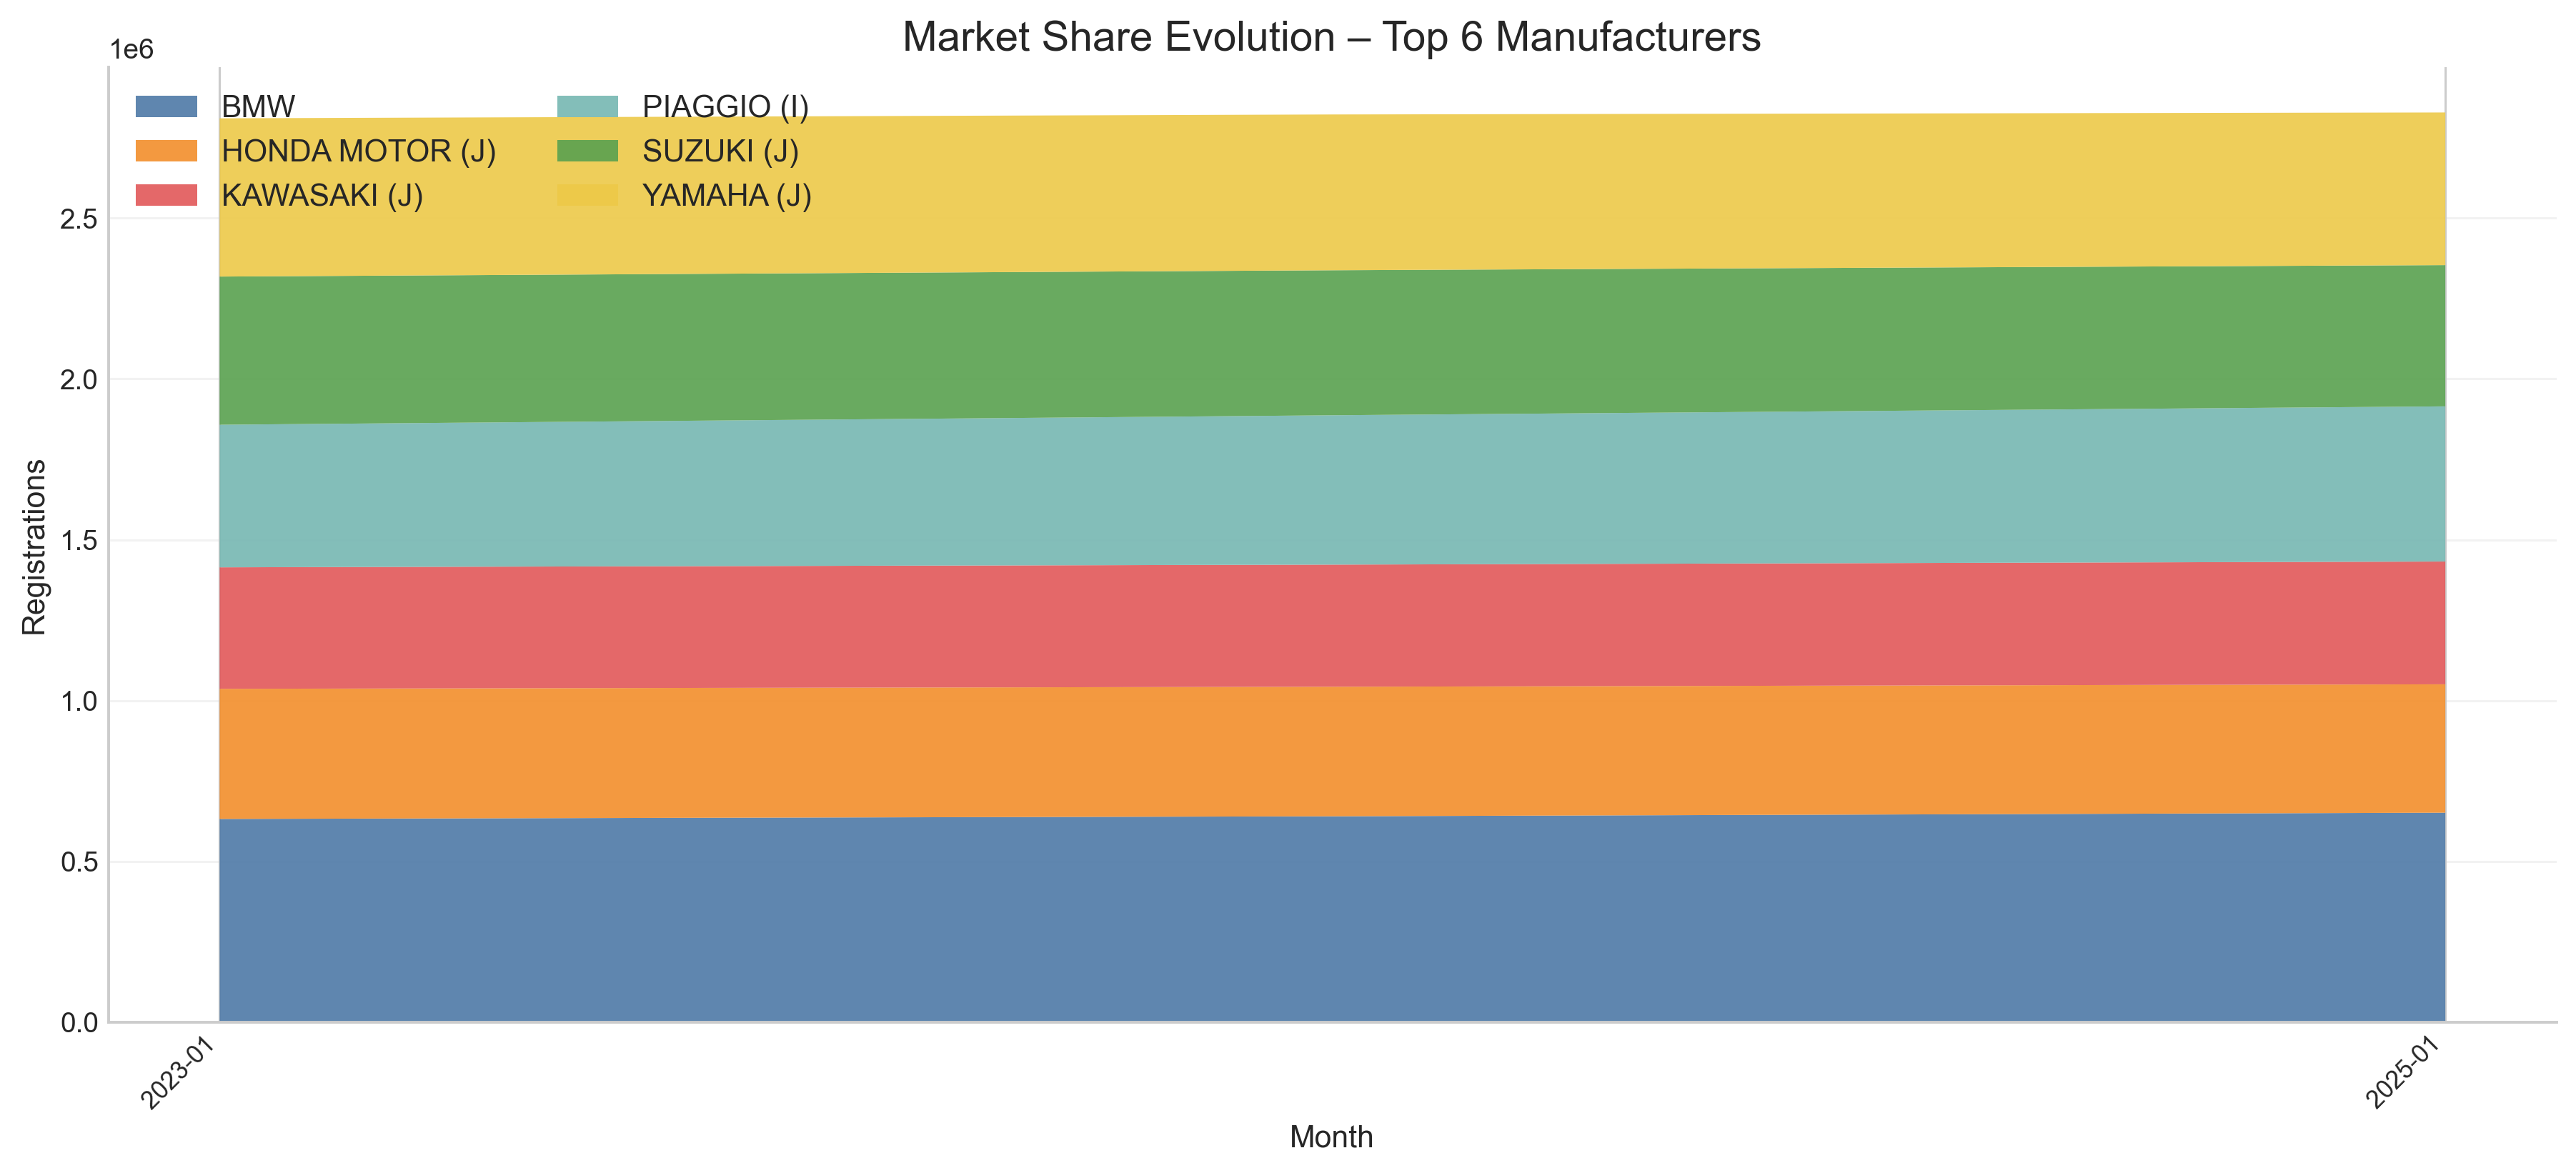

In [12]:
top6_names = (
    market_share.groupby("manufacturer")["registrations"]
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
    .tolist()
)

share_top6 = market_share[market_share["manufacturer"].isin(top6_names)]
pivot = share_top6.pivot(
    index="year_month",
    columns="manufacturer",
    values="registrations"
).fillna(0)

plt.figure(figsize=(13, 6))
ax = plt.gca()

ax.stackplot(
    pivot.index,
    pivot.T.values,
    labels=pivot.columns,
    colors=PALETTE[:pivot.shape[1]],
    alpha=0.9
)

ax.set_title("Market Share Evolution – Top 6 Manufacturers")
ax.set_xlabel("Month")
ax.set_ylabel("Registrations")
ax.legend(ncol=2, loc="upper left")
ax.set_xticks(pivot.index[::2])
ax.set_xticklabels(pivot.index[::2], rotation=45, ha="right")

apply_common_format(ax)
save_fig("04_market_share_evolution_multicolour")
plt.show()


📊 Chart 4 — Market Share Evolution (Top 6 Manufacturers)

What this chart shows?

How registrations for the top six manufacturers evolve over time.

Key finding:

While the overall market remains stable, relative positions among the top manufacturers shift gradually, indicating slow but persistent competitive dynamics.

Why this matters?

This confirms that:

 - The market is not volatile
 - Strategic shifts take time to materialize
 - Consistency and long-term positioning matter more than short-term spikes

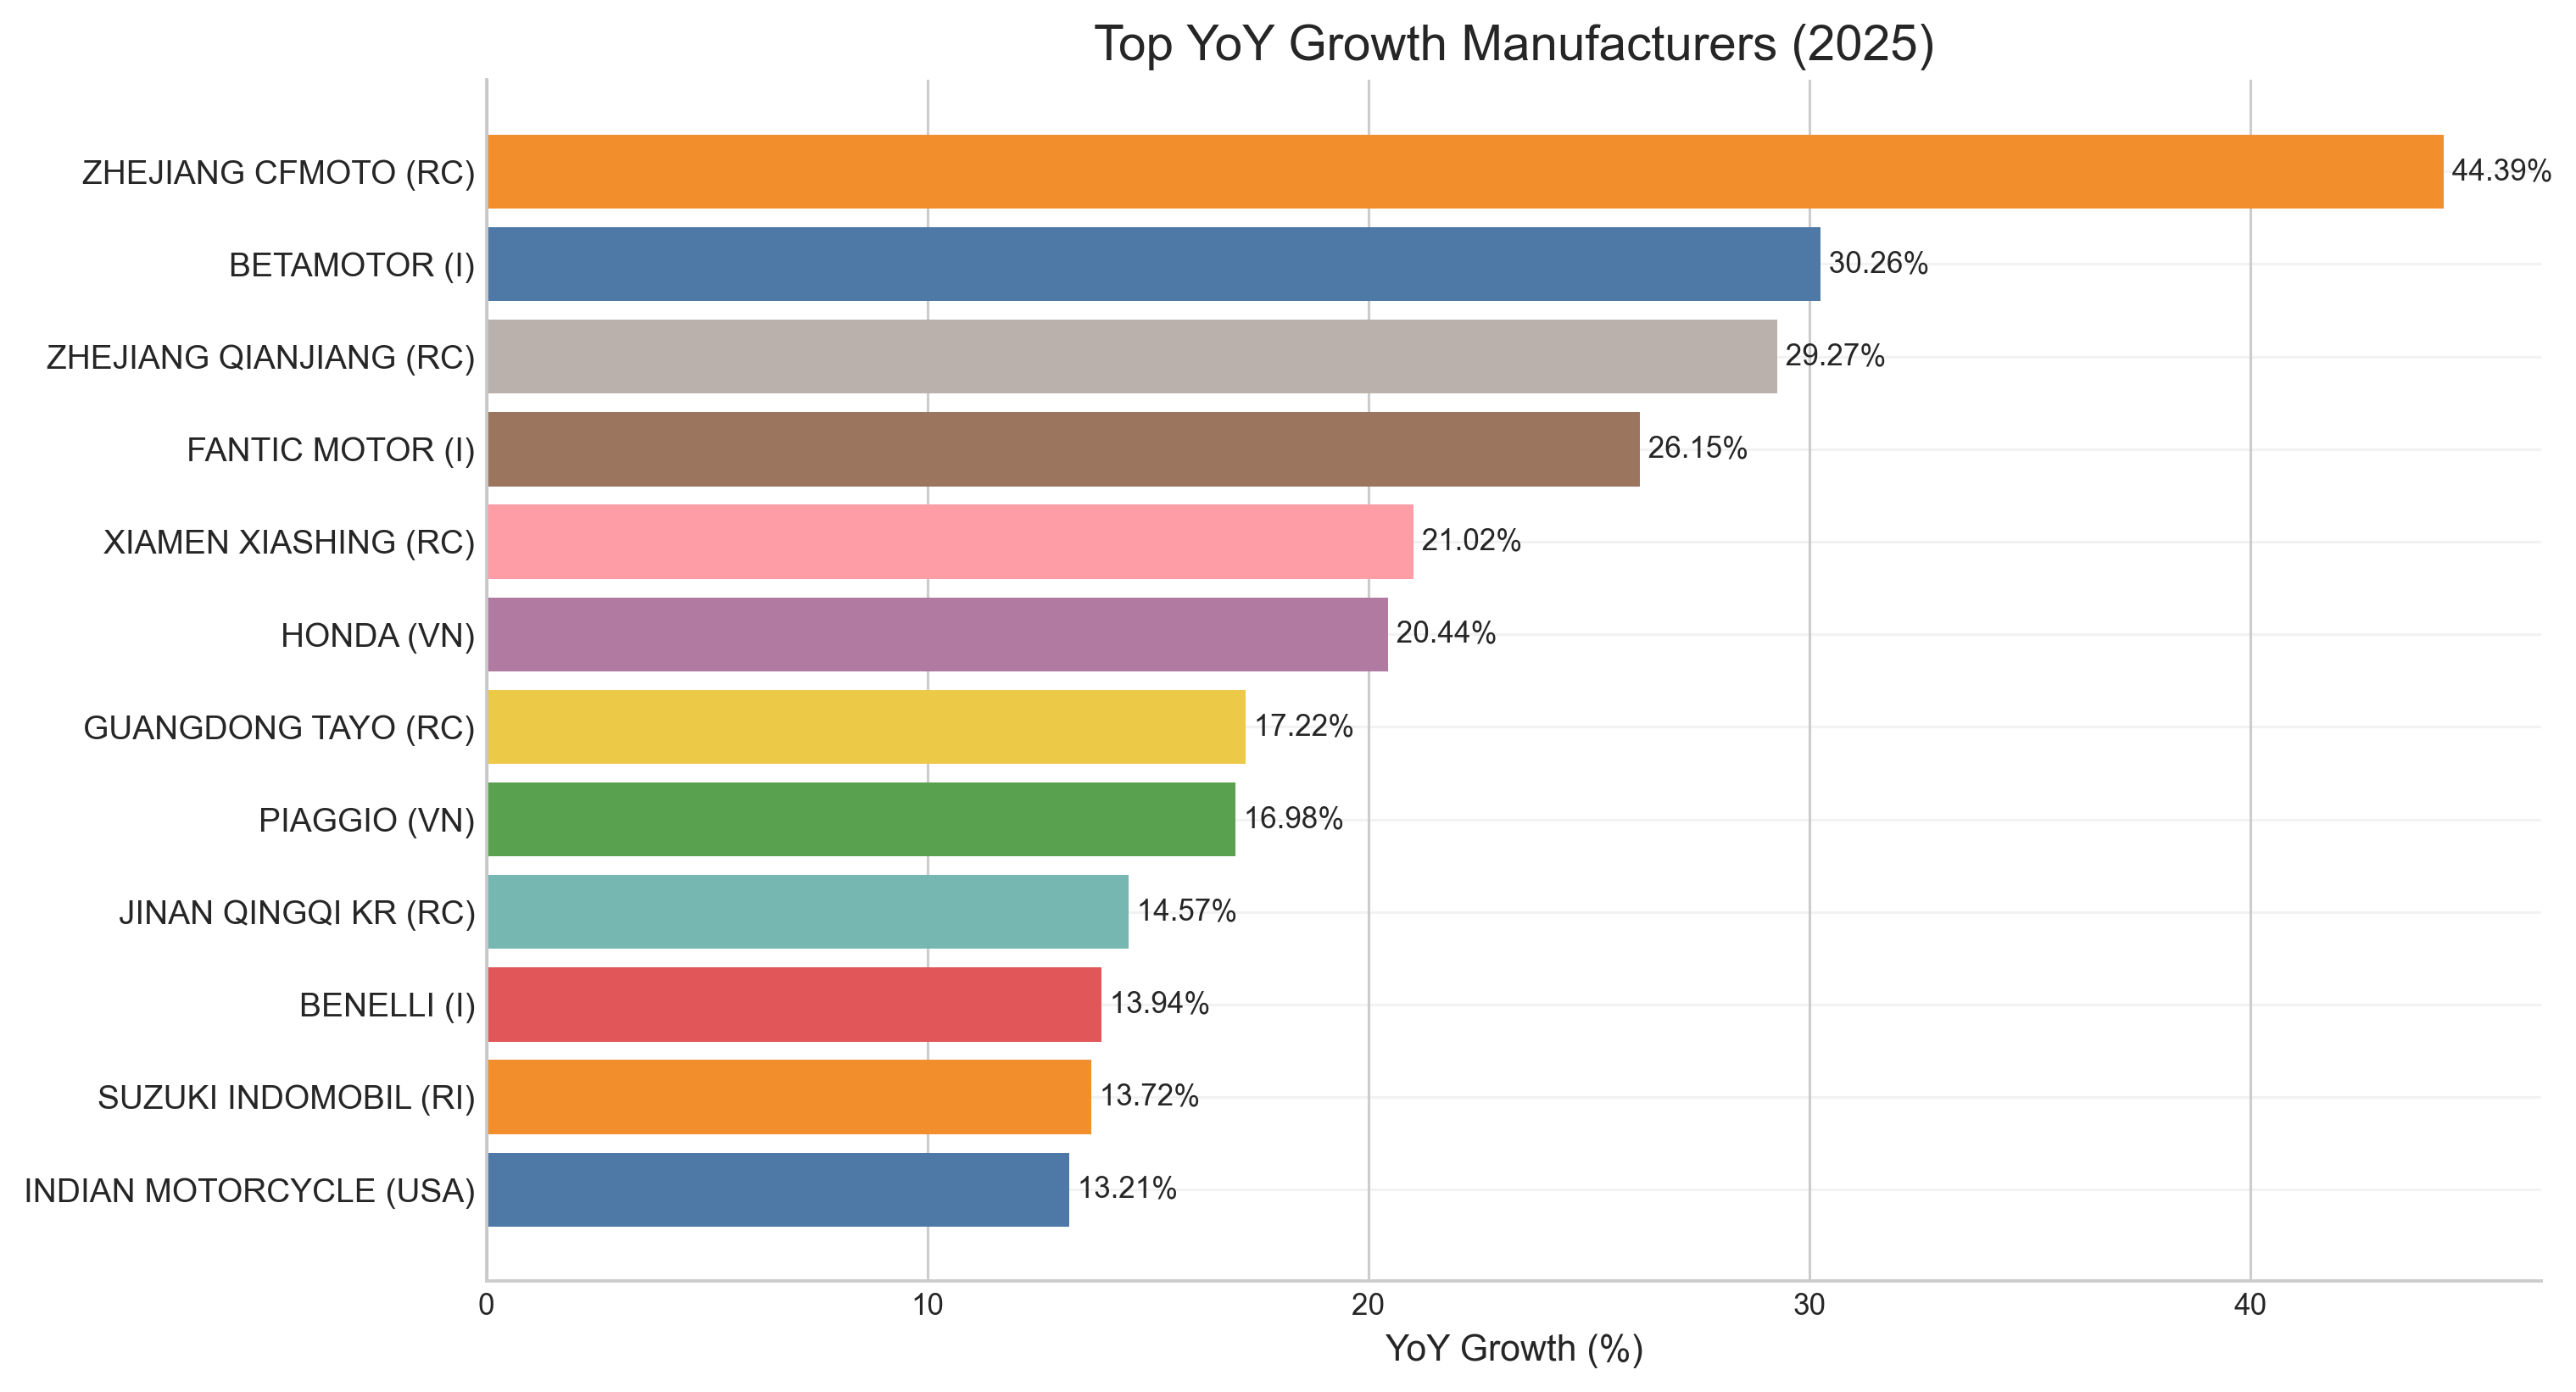

In [13]:
latest_year = yoy["year"].max()

yoy_latest = (
    yoy[(yoy["year"] == latest_year) & (yoy["yoy_growth_pct"].notna())]
    .sort_values("yoy_growth_pct", ascending=False)
    .head(12)
    .sort_values("yoy_growth_pct")
)

plt.figure(figsize=(11, 6))
ax = plt.gca()

ax.barh(
    yoy_latest["manufacturer"],
    yoy_latest["yoy_growth_pct"],
    color=PALETTE[:len(yoy_latest)]
)

ax.axvline(0, color="black", linewidth=1)
ax.set_title(f"Top YoY Growth Manufacturers ({int(latest_year)})")
ax.set_xlabel("YoY Growth (%)")

for i, v in enumerate(yoy_latest["yoy_growth_pct"]):
    ax.text(v, i, f" {v:.2f}%", va="center", fontsize=9)

apply_common_format(ax)
save_fig("05_yoy_growth_multicolour")
plt.show()


📊 Chart 5 — Top YoY Growth Manufacturers

What this chart shows?

Manufacturers with the highest year-over-year growth rates in the most recent year.

Key finding?

High YoY growth is typically concentrated among smaller or mid-sized manufacturers, while large incumbents show more stable but lower growth rates.

Why this matters?

This pattern is common in mature markets:

 - Smaller brands can grow faster off a smaller base 
 - Incumbents focus on defending share rather than rapid expansion
 - This chart helps identify potential future challengers worth deeper analysis.

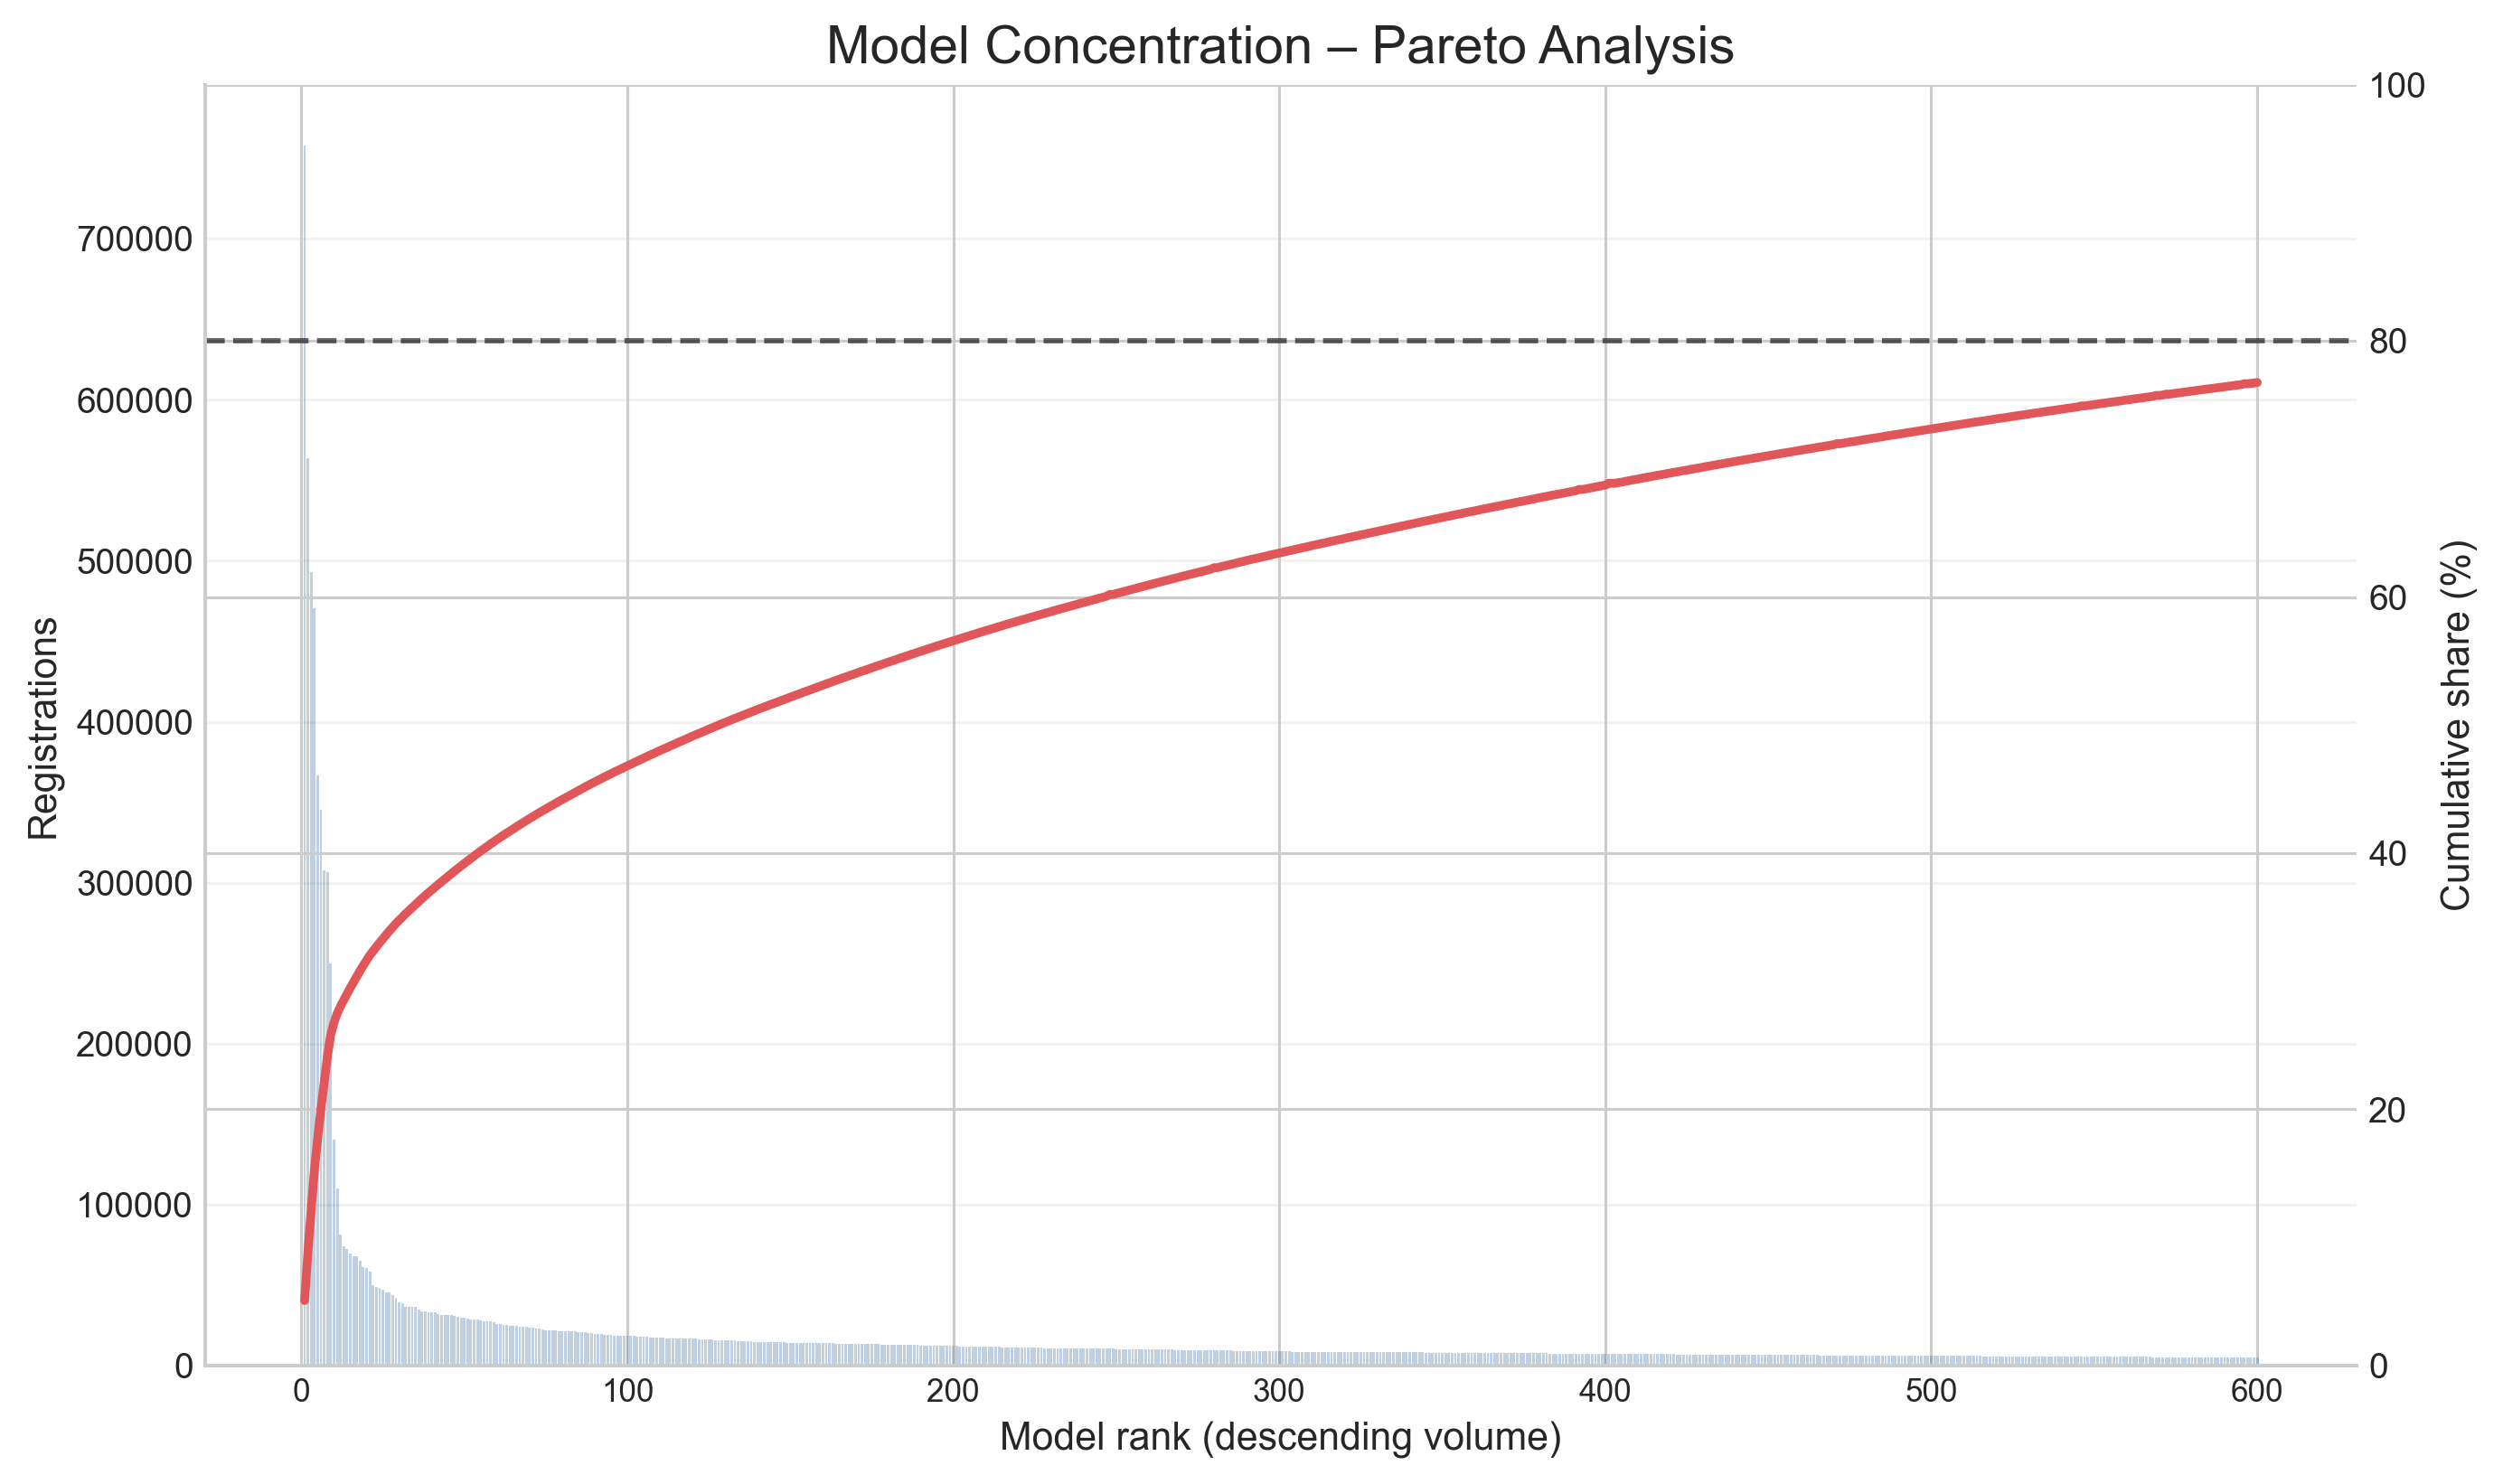

In [14]:
p = pareto.copy().head(600)
p["rank"] = range(1, len(p) + 1)

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.bar(
    p["rank"],
    p["registrations"],
    color=PALETTE[0],
    alpha=0.35,
    label="Registrations per model"
)

ax2 = ax.twinx()
ax2.plot(
    p["rank"],
    p["cumulative_share_pct"],
    color=PALETTE[2],
    linewidth=2.5,
    label="Cumulative share (%)"
)

ax2.axhline(80, linestyle="--", color="black", alpha=0.6)

ax.set_title("Model Concentration – Pareto Analysis")
ax.set_xlabel("Model rank (descending volume)")
ax.set_ylabel("Registrations")
ax2.set_ylabel("Cumulative share (%)")
ax2.set_ylim(0, 100)

apply_common_format(ax)
save_fig("06_pareto_multicolour")
plt.show()


📊 Chart 6 — Model Concentration (Pareto Analysis)

What this chart shows:

The cumulative contribution of individual motorcycle models to total registrations.

Key finding:

A small subset of models accounts for the majority of registrations, confirming a strong Pareto (80/20) effect.

Why this matters?

This insight has direct operational implications:

 - Analytics should prioritize top-selling models
 - Inventory and supply planning should focus on a limited set of SKUs
 - Long-tail models contribute marginally to volume but may support brand identity

In [16]:
con.close()